In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#!pip install pymc>=4

import pymc
import arviz as az
import xarray as xr

In [2]:
df = pd.read_csv('Competition_Data.csv')
df.head(10)

,Index,Fiscal_Week_ID,Store_ID,Item_ID,Price,Item_Quantity,Sales_Amount_No_Discount,Sales_Amount,Competition_Price
0,0,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,206.44
1,1,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,158.01
2,2,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,278.03
3,3,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,222.66
4,4,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,195.32
5,5,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,108.75
6,6,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,219.64
7,7,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,100.11
8,8,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,86.10
9,9,2019-11,store_459,item_526,134.49,435,4716.74,11272.59,231.21


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Index,100000.0,49999.500000,28867.657797,0.00,24999.7500,49999.50,74999.2500,99999.00
Price,100000.0,167.017783,69.503418,47.70,105.4100,159.42,221.9000,310.66
Item_Quantity,100000.0,399.611320,59.440567,285.00,348.0000,401.00,451.0000,522.00
Sales_Amount_No_Discount,100000.0,4771.147859,1524.737540,2003.70,3481.4600,4746.53,6045.4775,7853.81
Sales_Amount,100000.0,11396.865217,2091.246764,7613.56,9551.5900,11240.02,13175.2300,15685.08
Competition_Price,100000.0,174.280887,71.545584,47.95,118.6275,162.51,237.3350,313.64


>> Elasticity (coefficient) can be calculated at an individual SKU level or at a segment level.

>> Data used is for an item across multiple stores.

In [4]:
dff = df.loc[df['Item_ID'] == 'item_526']
dff.info()

<class 'pandas.core.frame.DataFrame'>
Index: 560 entries, 0 to 79899
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Index                     560 non-null    int64  
 1   Fiscal_Week_ID            560 non-null    object 
 2   Store_ID                  560 non-null    object 
 3   Item_ID                   560 non-null    object 
 4   Price                     560 non-null    float64
 5   Item_Quantity             560 non-null    int64  
 6   Sales_Amount_No_Discount  560 non-null    float64
 7   Sales_Amount              560 non-null    float64
 8   Competition_Price         560 non-null    float64
dtypes: float64(4), int64(2), object(3)
memory usage: 43.8+ KB


In [5]:
dff.describe()

,Index,Price,Item_Quantity,Sales_Amount_No_Discount,Sales_Amount,Competition_Price
count,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000
mean,41431.285714,132.032911,444.571429,4729.203625,11344.707411,174.699107
std,28320.287071,3.774623,13.698200,136.156351,299.659288,70.279587
min,0.000000,125.670000,424.000000,4518.480000,10810.390000,53.560000
25%,19649.750000,128.650000,433.000000,4630.740000,11168.100000,114.217500
50%,40269.500000,131.400000,445.000000,4704.890000,11320.760000,181.510000
75%,60299.250000,135.100000,458.000000,4848.802500,11544.720000,222.517500
max,79899.000000,138.670000,467.000000,4974.390000,11877.210000,303.600000


In [6]:
print(round(dff['Price'].std(), 2))

3.77


In [20]:
print(round(dff['Item_Quantity'].std(), 2))

13.7


Text(0, 0.5, 'Quantity')

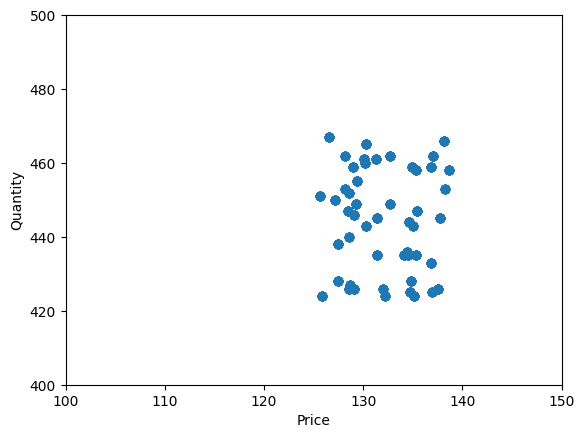

In [7]:
plt.scatter(x = dff['Price'], y = dff['Item_Quantity'])      #PPU is price per unit/item
#plt.title('')
plt.ylim([400, 500])
plt.xlim([100, 150])
plt.xlabel('Price')
plt.ylabel('Quantity')

> Lets fit a **Bayesian linear regression** model to this data.

>> Non-linear elasiticity is given by percentage change in quantity due to  percentage change in price.


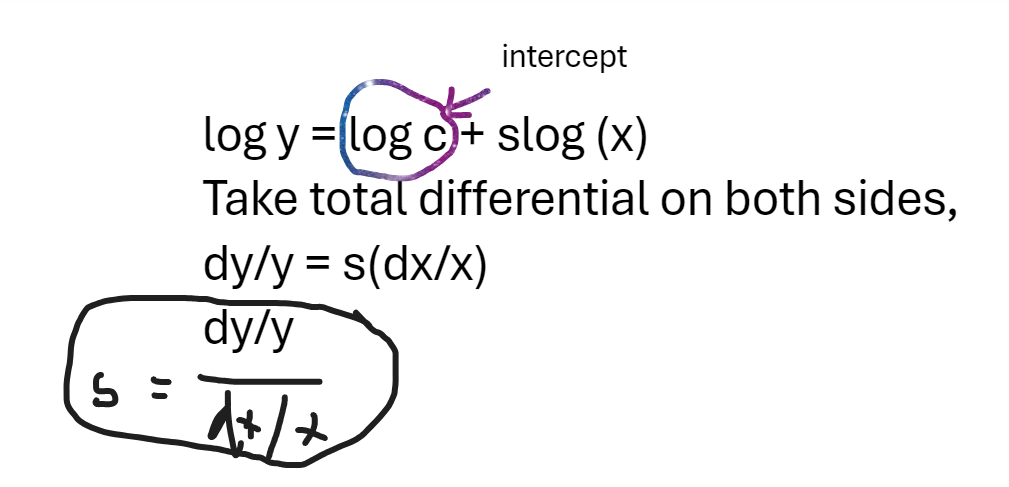

>> Also, we consider a single variable (not multiple) regression model.  Competition price could be another regressor.

>> Quantifying uncertainty: We do not get a single estimate of
 beta, instead a complete posterior distribution about how likely different values of beta are. For example, with few data points our uncertainty in
 beta will be very high and we’d be getting very wide posteriors.

In [8]:
x = dff['Price'].values
y = dff['Item_Quantity'].values

In [9]:
with pymc.Model() as glm:
    #Define prior distributions for intercept and regression coefficients
    sigma = pymc.HalfCauchy("sigma", beta = 10)
    intercept = pymc.Normal("Intercept", mu = 0, sigma = 1.0)
    slope = pymc.Normal("slope", mu = 0.0, sigma = 1.0)

    #setup model with Normal likelihood
    likelihood = pymc.Normal("y", mu = intercept + slope * x, sigma = sigma, observed = y)

    trace_glm = pymc.sample(draws = 3000, tune = 100, discard_tuned_samples = True)   #draw 3000 posterior samples

Output()

Output()

>> Number of iterations to tune is specified as an argument, defaults to 1000. Samplers adjust the step sizes during tuning. Tuning samples will be drawn in addition to the number specified in the 'draws' argument, and will be discarded unless 'discard_tuned_samples' is set to False.

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>]], dtype=object)

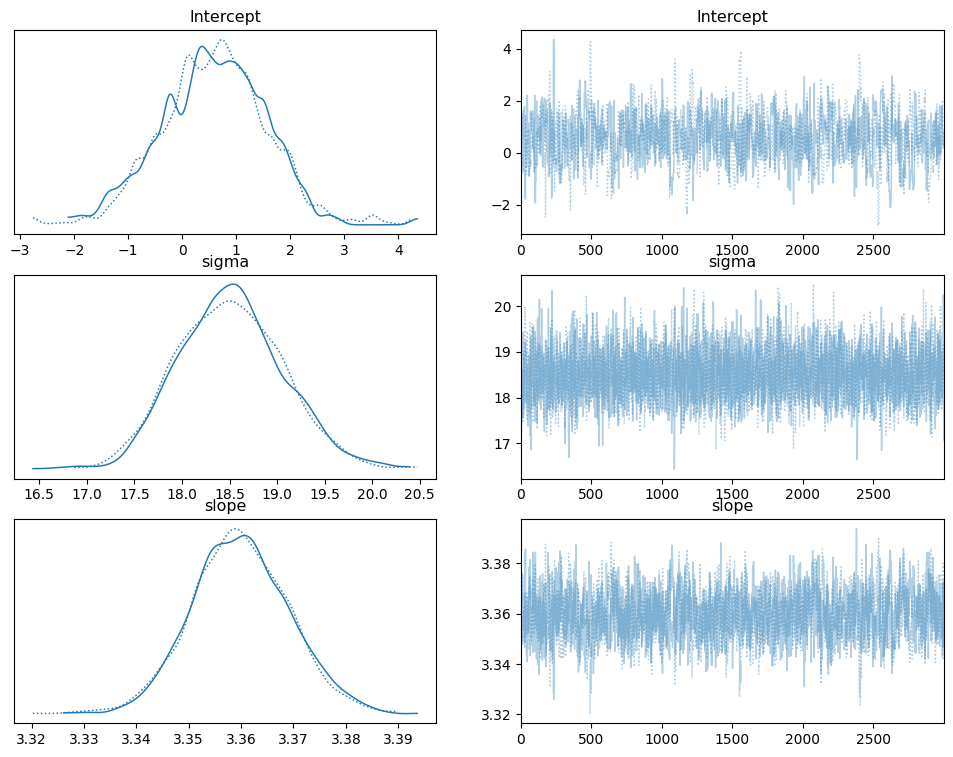

In [11]:
az.plot_trace(trace_glm, figsize = (12, 9))

In [12]:
az.summary(trace_glm)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.588,0.960,-1.209,2.281,0.038,0.027,650.0,820.0,1.0
sigma,18.510,0.551,17.498,19.536,0.010,0.007,3151.0,2768.0,1.0
slope,3.360,0.009,3.342,3.377,0.000,0.000,931.0,1626.0,1.0


array([<Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'sigma'}>,
       <Axes: title={'center': 'slope'}>], dtype=object)

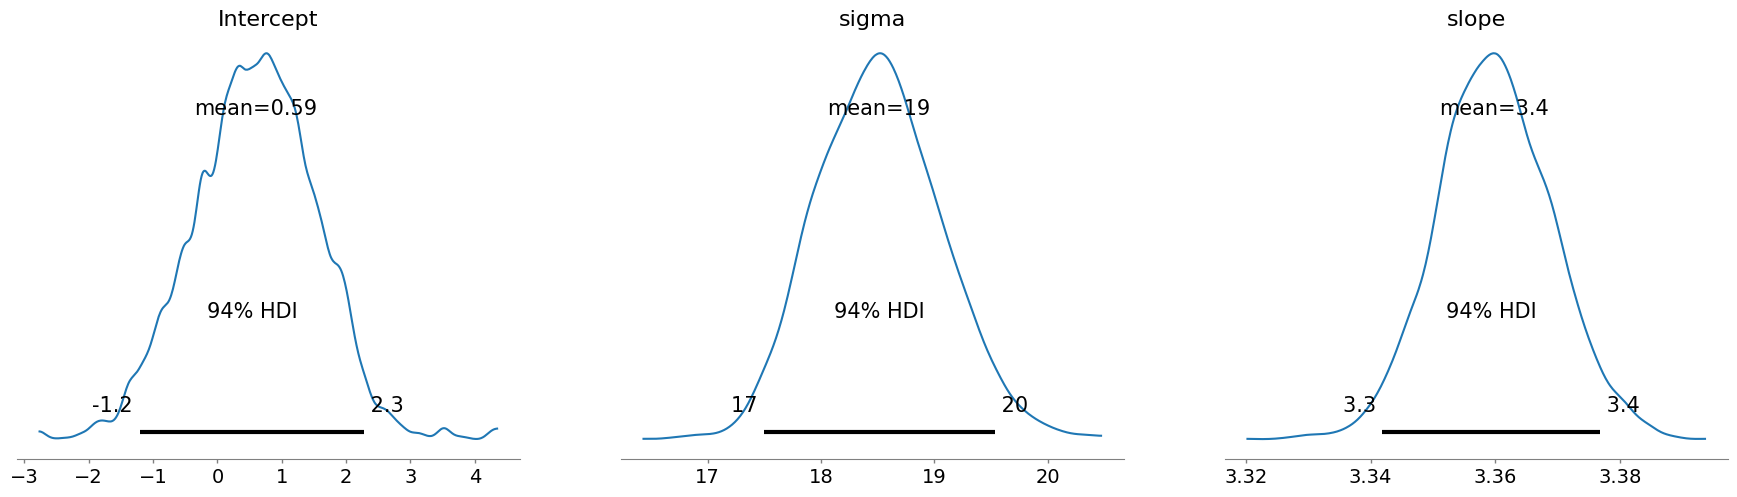

In [13]:
az.plot_posterior(trace_glm)

In [14]:
data = pd.DataFrame({"x": x, "y": y})

In [15]:
!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.3 MB/s eta 0:00:00


In [16]:
import bambi

model = bambi.Model("y ~ x", data)
idata = model.fit(draws = 3000)

Output()

Output()

In [17]:
idata.posterior["y_model"] = idata.posterior["Intercept"] + idata.posterior["x"] * xr.DataArray(x)

/usr/local/lib/python3.10/dist-packages/arviz/plots/lmplot.py:212: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)


Text(0.5, 0, 'x')

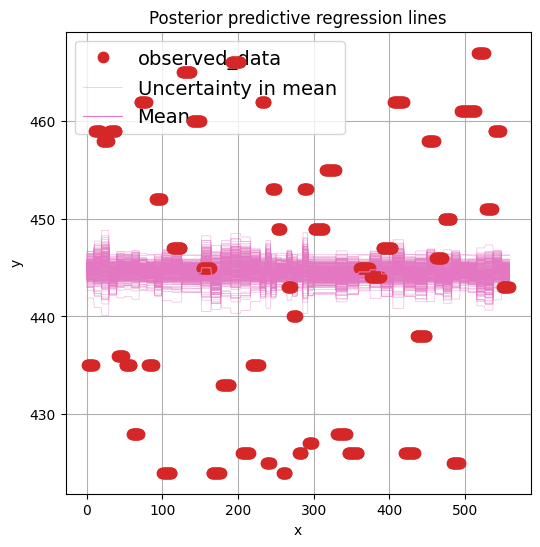

In [18]:
_, ax = plt.subplots(figsize = (6, 6))
az.plot_lm(idata = idata, y = "y", num_samples = 300, axes = ax, y_model = "y_model")
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x")

>> The trace plot represents the KDE and convergence of the model.

> **Bayesian hierarchical model**

In [21]:
occurences = np.random.normal(444.57, 13.7, 560)

with pymc.Model() as hierarchical_model:
    #priors
    prior_sigma = pymc.HalfCauchy("prior_sigma", beta = 5)
    prior_mu = pymc.Normal('prior_mu', mu = 132.03, sigma = 3.77)
    intercept = pymc.Normal("Intercept", mu = 0.0, sigma = 1.0)
    slope = pymc.Normal("slope", mu = 0.0, sigma = 1.0)

    likelihood = pymc.Normal("y", mu = prior_mu, sigma = prior_sigma, observed = occurences)

    #trace = pymc.sample(draws = 3000, target_accept = 0.97)
    trace =  pymc.sample(draws = 3000, tune = 100, discard_tuned_samples = True)

Output()

Output()

>> In the NUTS sampling method, 'target_accept' is a float in [0, 1]. The step-size is tuned such that the acceptance rate is approximated. Higher values like 0.95 often work better for problematic posteriors. This argument can be passed directly to sample.

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'prior_mu'}>,
        <Axes: title={'center': 'prior_mu'}>],
       [<Axes: title={'center': 'prior_sigma'}>,
        <Axes: title={'center': 'prior_sigma'}>],
       [<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>]], dtype=object)

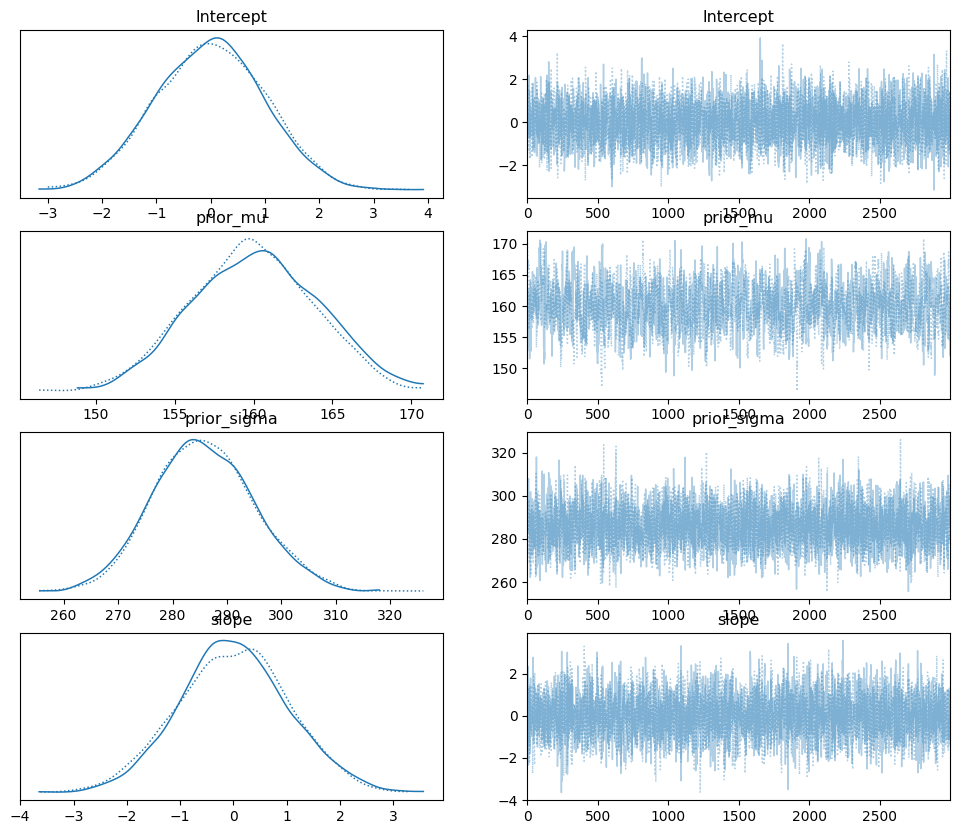

In [22]:
az.plot_trace(trace, figsize = (12, 10))

array([<Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'prior_mu'}>,
       <Axes: title={'center': 'prior_sigma'}>,
       <Axes: title={'center': 'slope'}>], dtype=object)

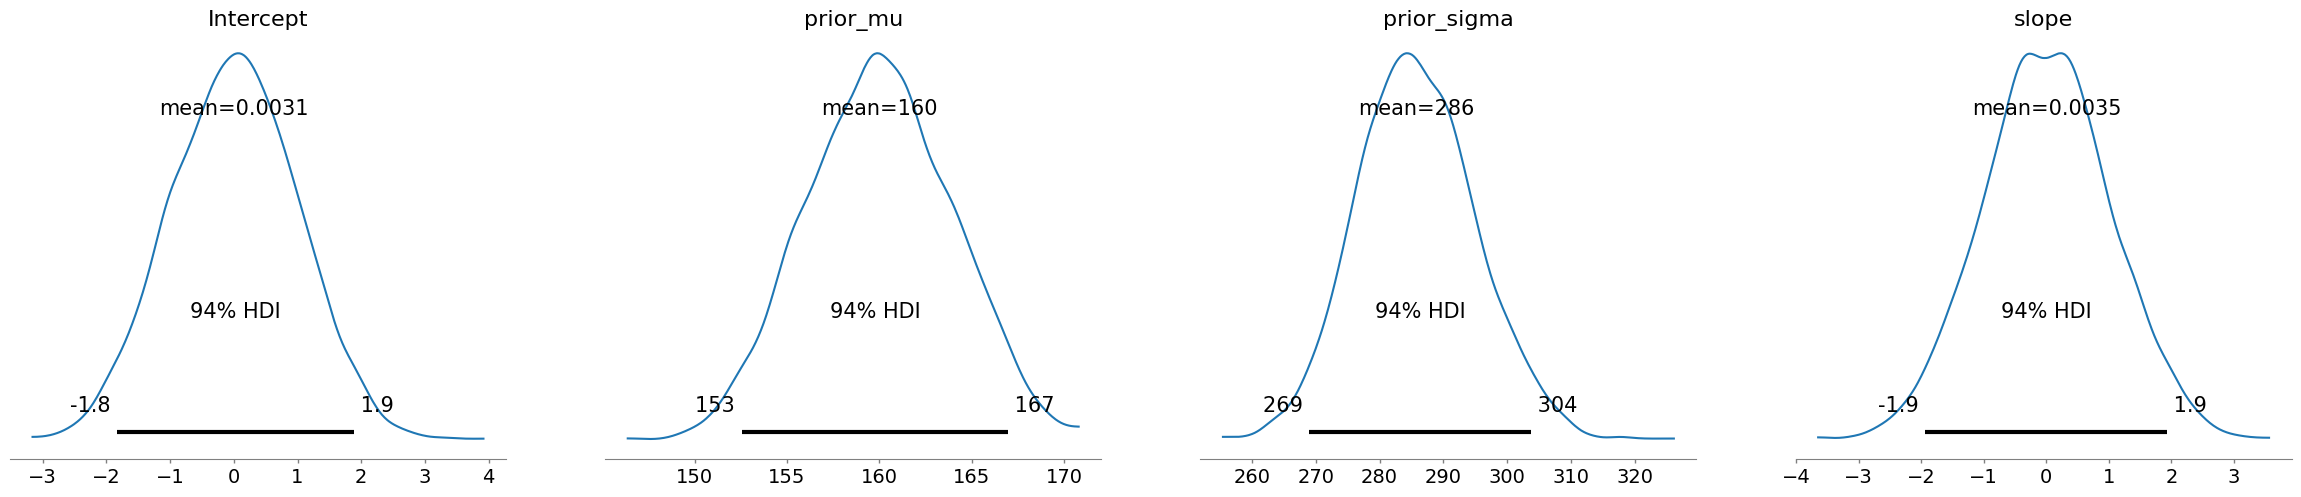

In [23]:
az.plot_posterior(trace)

array([[<Axes: ylabel='prior_mu'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='prior_sigma'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='Intercept', ylabel='slope'>,
        <Axes: xlabel='prior_mu'>, <Axes: xlabel='prior_sigma'>]],
      dtype=object)

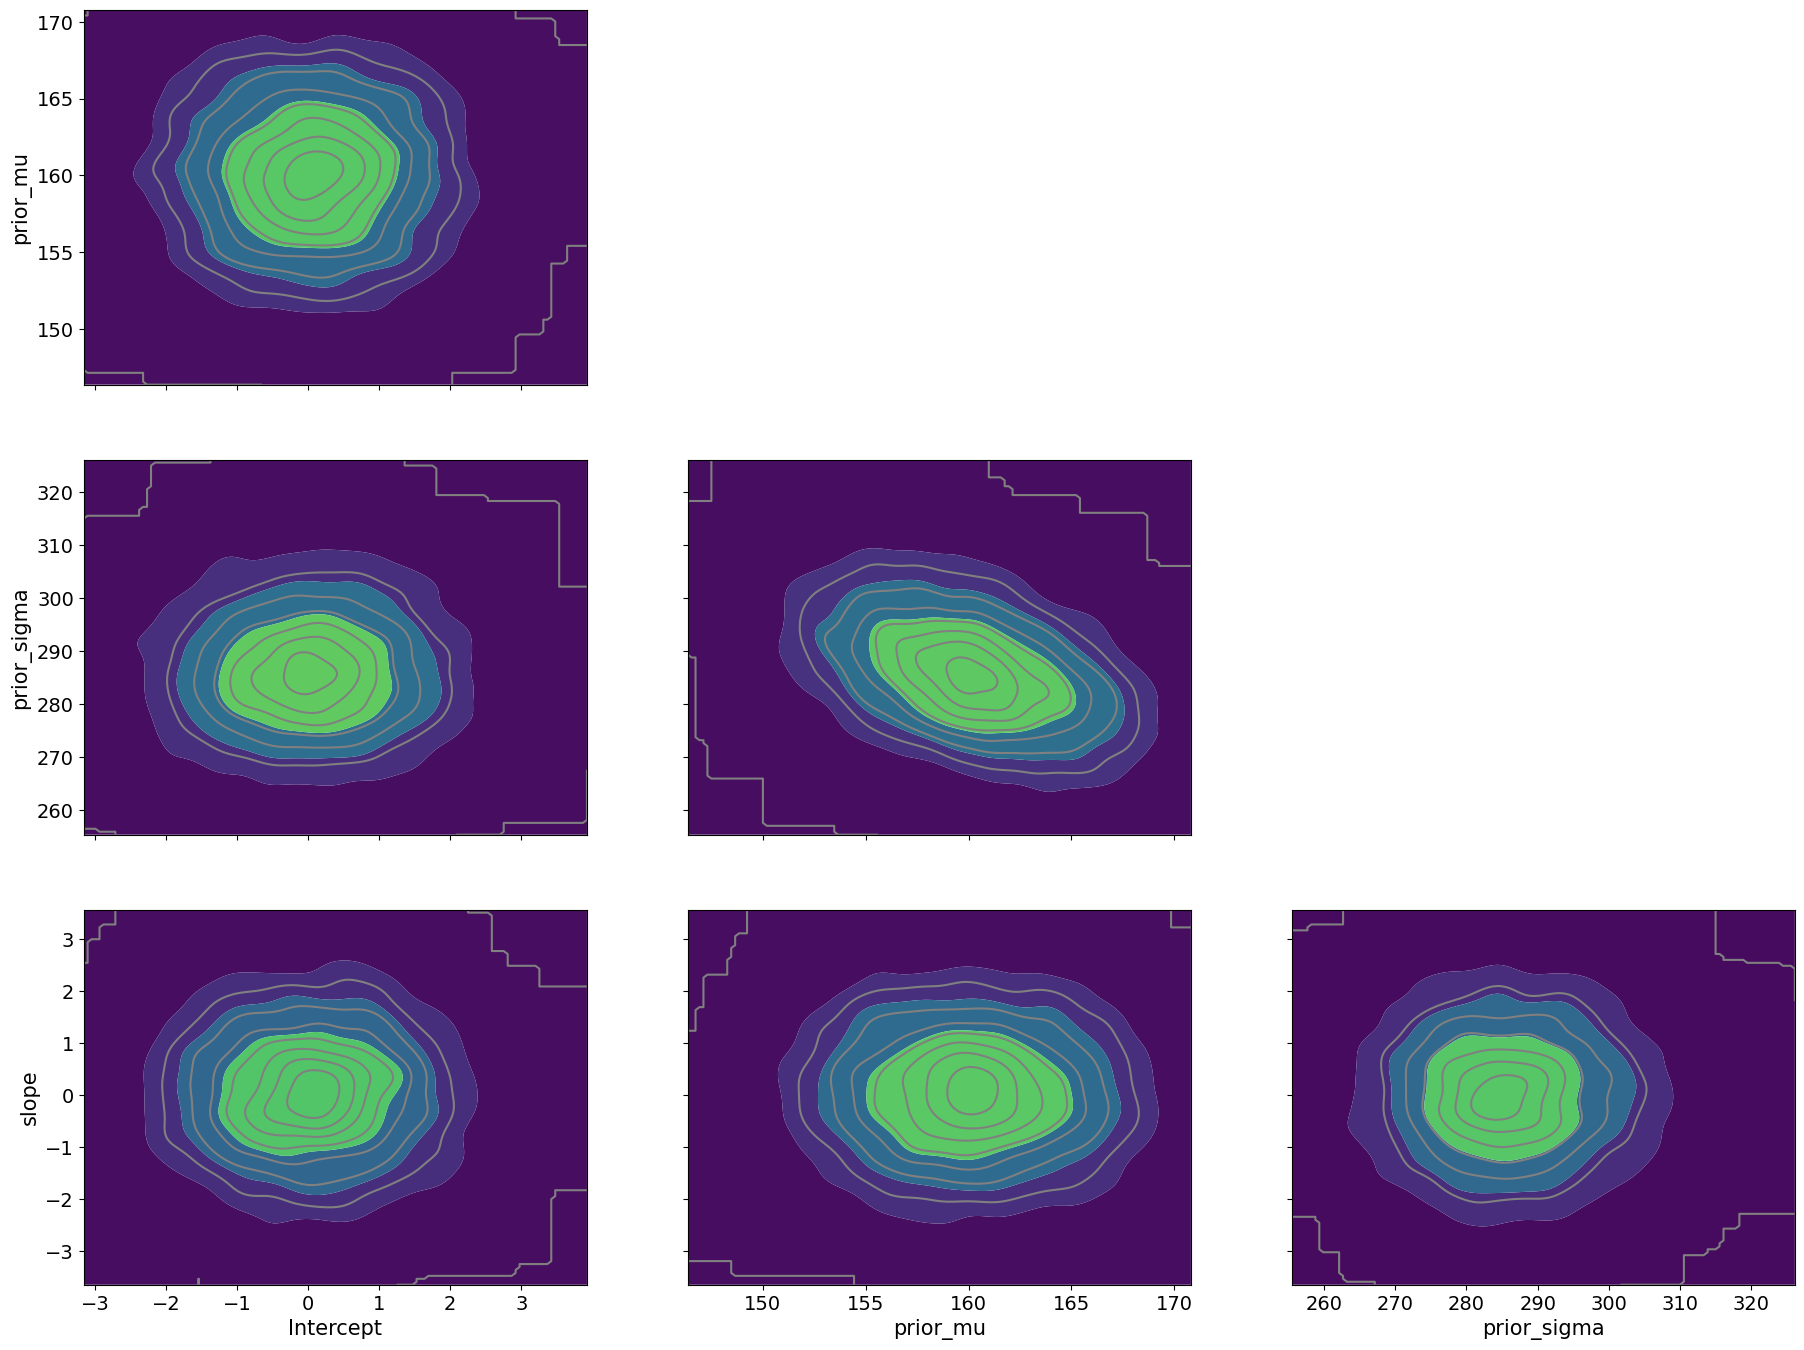

In [24]:
az.plot_pair(trace, kind = 'kde')

In [25]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.003,0.995,-1.833,1.884,0.015,0.015,4478.0,3292.0,1.0
prior_mu,160.001,3.898,152.540,166.960,0.124,0.088,991.0,1227.0,1.0
prior_sigma,285.818,9.282,269.005,303.780,0.154,0.109,3618.0,3894.0,1.0
slope,0.004,1.026,-1.935,1.926,0.015,0.016,4628.0,3200.0,1.0


In [26]:
#trace.observed_data

In [27]:
#trace.posterior

In [28]:
#trace.sample_stats

> Change the number of observations in the likelihood function and see the impact.

In [29]:
occurences = np.random.normal(444.57, 13.7, 1200)

with pymc.Model() as hierarchical_model:
    #priors
    prior_sigma = pymc.HalfCauchy("prior_sigma", beta = 5)
    prior_mu = pymc.Normal('prior_mu', mu = 132.03, sigma = 3.77)
    intercept = pymc.Normal("Intercept", mu = 0.0, sigma = 1.0)
    slope = pymc.Normal("slope", mu = 0.0, sigma = 1.0)

    likelihood = pymc.Normal("y", mu = prior_mu, sigma = prior_sigma, observed = occurences)

    #trace = pymc.sample(draws = 3000, target_accept = 0.97)
    trace =  pymc.sample(draws = 3000, tune = 100, discard_tuned_samples = True)

Output()

Output()

In [30]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.031,1.006,-1.808,1.951,0.016,0.015,3938.0,2958.0,1.0
prior_mu,202.760,4.360,194.835,211.075,0.143,0.101,924.0,1182.0,1.0
prior_sigma,241.830,6.607,230.360,255.129,0.152,0.107,1894.0,2854.0,1.0
slope,-0.006,1.005,-1.834,2.002,0.015,0.015,4637.0,3650.0,1.0


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'prior_mu'}>,
        <Axes: title={'center': 'prior_mu'}>],
       [<Axes: title={'center': 'prior_sigma'}>,
        <Axes: title={'center': 'prior_sigma'}>],
       [<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>]], dtype=object)

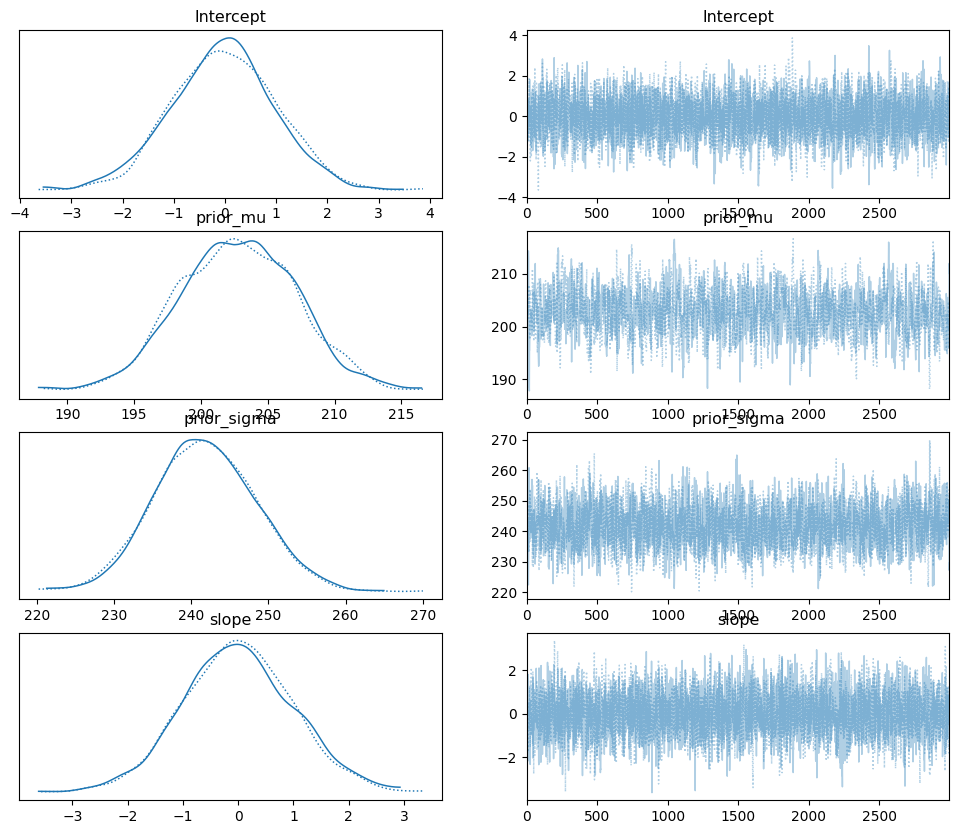

In [32]:
az.plot_trace(trace, figsize = (12, 10))

array([<Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'prior_mu'}>,
       <Axes: title={'center': 'prior_sigma'}>,
       <Axes: title={'center': 'slope'}>], dtype=object)

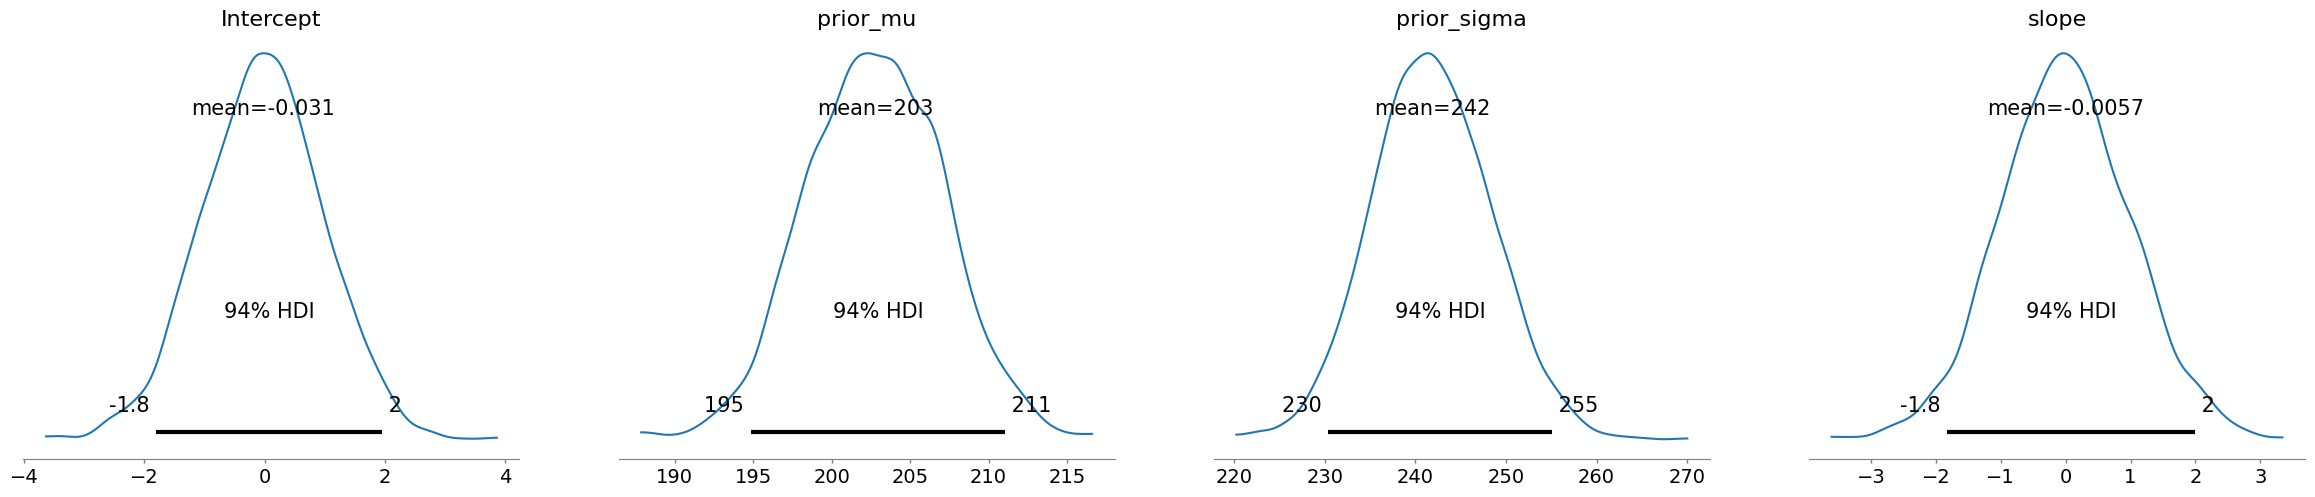

In [33]:
az.plot_posterior(trace)